In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10

img1 = cv2.imread('1.bmp',0)         
img2 = cv2.imread('2.bmp',0) 

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [3]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    
    matchesMask = mask.ravel().tolist()
    
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    #img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None
    
print(M)

[[ 9.92370147e-01  8.75808040e-02  6.15203913e+01]
 [-1.55192914e-01  1.15963670e+00 -1.68170624e+01]
 [-4.24073521e-04  1.41799698e-05  1.00000000e+00]]


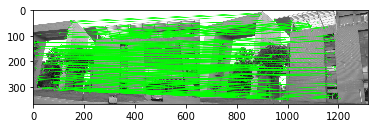

(<matplotlib.image.AxesImage at 0x278c14ac978>, None)

In [4]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()

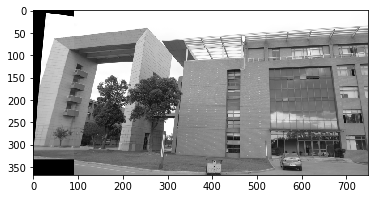

True

In [8]:
def warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homograph H'''
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
    return result

dst_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
src_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

result = warpTwoImages(img1, img2, M)
plt.imshow(result, 'gray'),plt.show()
cv2.imwrite('result.jpg',result)